In [1]:
import os
import cv2
import random
import numpy as np
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Layer,Conv2D,MaxPooling2D,Input,Flatten,Dense
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
#import the uuid library to generate unique image names 
import uuid #which stands for universally unique identifiers

In [4]:
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative')
ANC_PATH = os.path.join('data','anchor')

In [5]:
cap=cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame = cap.read()
    frame = frame[155:405,200:450,:]
    
    #to collect an anchor image 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        #create unique file path1
        imgname= os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))
        #write anchor img
        cv2.imwrite(imgname,frame)
    #to collect positive images
    if cv2.waitKey(1) & 0XFF== ord('p'):
        imgname= os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)
    cv2.imshow("Face Recog Data collection",frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


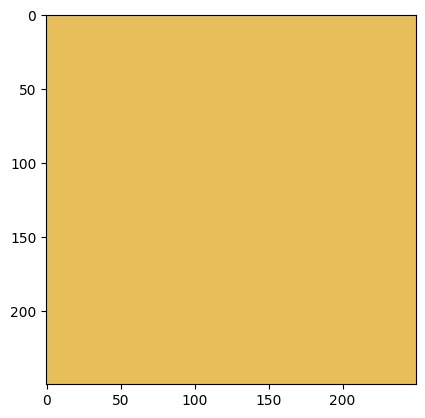

In [6]:
plt.imshow(frame)

In [7]:
frame.shape

(250, 250, 3)

In [8]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(1000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(1000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(1000)


In [9]:
dir_test = anchor.as_numpy_iterator()

In [10]:
dir_test.next()

b'data\\anchor\\a08c182f-f1ea-11ee-8c4a-48e7daf4f3ca.jpg'

In [11]:
def preprocess(file_path):
    #read in image from file path
    byte_img = tf.io.read_file(file_path)
    #load in the image
    img = tf.io.decode_jpeg(byte_img)
    #resizing the image
    img = tf.image.resize(img,(100,100))
    #scaling the image
    img = img/255.0
    
    return img

In [12]:
image = preprocess(r"C:\Users\Aniket\Desktop\codes\self projects\data\positive\0f857655-f17b-11ee-ac0e-48e7daf4f3ca.jpg")

In [13]:
image.numpy().max()

0.735049

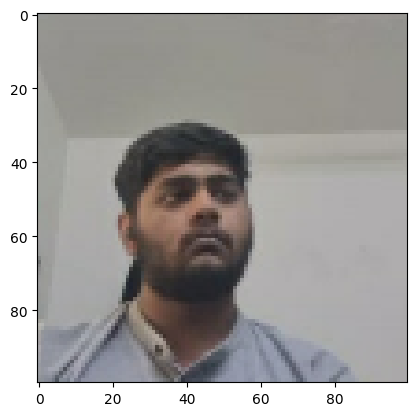

In [14]:
plt.imshow(image)

(anchor, positive) => 1,1,1,1,1

(anchor, negative) => 0,0,0,0,0

In [15]:
positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

## Build train and test partition

In [16]:
def preprocess_twin(input_img,validation_img,label):
    return(preprocess(input_img),preprocess(validation_img),label)

In [17]:
#build dataloader pipeline 
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [18]:
samples =data.as_numpy_iterator()

In [79]:
samp = samples.next()

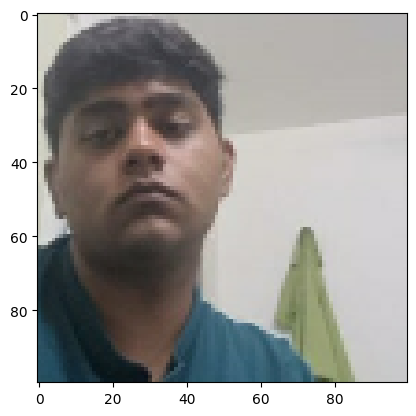

In [80]:
plt.imshow(samp[0])

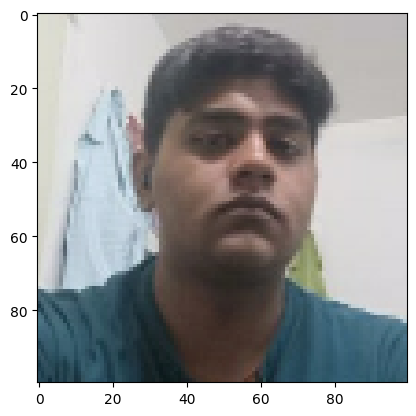

In [81]:
plt.imshow(samp[1])

In [78]:
samp[2]

1.0

Above 4 code helps to understand what and how every thing is happening , like samp[2] ==0 means that it is a negative image , and samp[1] is positive

### Training partition 

In [23]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

### Testing data

In [24]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

## Making the embedding layer

In [25]:
def make_embedding():
    inp = Input(shape=(100,100,3),name='input_image')
    
    #firstblock of code 
    c1 = Conv2D(64,(10,10),activation='relu')(inp)
    m1 = MaxPooling2D(64,(2,2),padding='same')(c1)
    
    #second block of code
    c2 = Conv2D(128,(7,7),activation='relu')(m1)
    m2 = MaxPooling2D(64,(2,2),padding='same')(c2)
    
    #third block of code
    c3 = Conv2D(128,(4,4),activation='relu')(m2)
    m3 = MaxPooling2D(64,(2,2),padding='same')(c3)
    
    #final embedding code
    c4 = Conv2D(256,(4,4),activation = 'relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096,activation = 'sigmoid')(f1)
    

    return Model(inputs = [inp] ,outputs = [d1],name = 'embedding')

In [26]:
embedding=make_embedding()

In [27]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

###  build distance layer 

In [28]:
class L1Dist(Layer):
    def __init__(self,**kwargs):
        super().__init__()
    def call(self,input_embedding,validation_embedding):
        return tf.math.abs(input_embedding-validation_embedding)

In [29]:
l1 = L1Dist()

In [30]:
l1

### Siamese model making

In [31]:
inpu = Input(name='input_img',shape = (100,100,3))
valu = Input(name='verification_img',shape = (100,100,3))


In [32]:
inp_emb = embedding(inpu)
val_emb = embedding(valu)

In [33]:
val_emb

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [34]:
def make_siamese_model():
    input_image = Input(name='input_image',shape=(100,100,3))
    
    validation_image = Input(name='validation_image',shape=(100,100,3))
    
    siamese_layer = L1Dist()
    siamese_layer._name='distance'
    distances = siamese_layer(embedding(input_image),embedding(validation_image))
    
    classifier = Dense(1,activation='sigmoid')(distances)
    
    return Model(inputs = [input_image, validation_image],outputs = classifier,name = 'SiameseNetwork')

In [35]:
siamese_model = make_siamese_model()

In [36]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_image (InputLayer)  [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_image[0][0]',            
                                                                  'validation_image[0

## Training the model 

In [37]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [38]:
opt = tf.keras.optimizers.Adam(1e-4) #0.0001

In [39]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt,siamese_model=siamese_model)

In [40]:
test_batch = train_data.as_numpy_iterator()

In [41]:
batch_1 = test_batch.next()

In [42]:
X = batch_1[:2]

In [43]:
y = batch_1[2]

In [44]:
y

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

In [45]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [46]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [47]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [48]:
EPOCHS = 50

In [49]:
train(train_data, EPOCHS) 


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
88/88 [==============================] - 53s 527ms/step

 Epoch 2/50
88/88 [==============================] - 43s 496ms/step

 Epoch 3/50
88/88 [==============================] - 43s 486ms/step

 Epoch 4/50
88/88 [==============================] - 41s 474ms/step

 Epoch 5/50
88/88 [==============================] - 40s 457ms/step

 Epoch 6/50
88/88 [==============================] - 37s 426ms/step

 Epoch 7/50
88/88 [==============================] - 37s 424ms/step

 Epoch 8/50
88/88 [==============================] - 36s 411ms/step

 Epoch 9/50
88/88 [==============================] - 35s 402ms/step

 Epoch 10/50
88/88 [==============================] - 35s 403ms/step

 Epoch 11/50
88/88 [==============================] - 36s 411ms/step

 Epoch 12/50
88/88 [==============================] - 36s 409ms/step

 Epoch 13/50
8

## Model Evaluation

In [50]:
from tensorflow.keras.metrics import Precision, Recall

In [51]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [52]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 145ms/step


In [53]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1]

In [54]:
y_true

array([0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1.],
      dtype=float32)

In [55]:
m = Recall()

m.update_state(y_true, y_hat)

m.result().numpy()

1.0

In [56]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 23ms/step
1.0 0.9959184


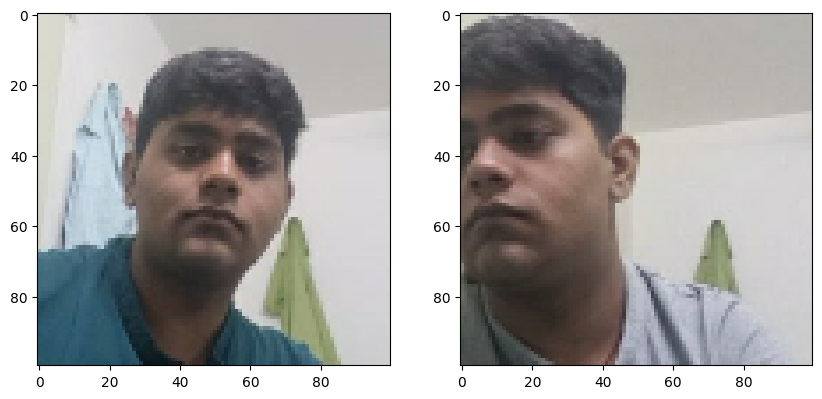

In [57]:
plt.figure(figsize=(10,8))


plt.subplot(1,2,1)
plt.imshow(test_input[3])


plt.subplot(1,2,2)
plt.imshow(test_val[3])


plt.show()

## Saving and loading model

In [58]:
siamese_model.save('siamesemodel.h5')

In [59]:
L1Dist

__main__.L1Dist

In [60]:
siamese_model = tf.keras.models.load_model('siamesemodel.h5', 
                    custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [61]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 110ms/step


array([[3.0159701e-12],
       [9.9999070e-01],
       [1.1484136e-12],
       [9.9999928e-01],
       [9.6898141e-13],
       [9.9996662e-01],
       [1.4969321e-11],
       [3.0470951e-12]], dtype=float32)

In [62]:
siamese_model = tf.keras.models.load_model('siamesemodel.h5', 
                    custom_objects={'L1Dist': L1Dist})

# Compile the model manually
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Make predictions with the reloaded model
predictions = siamese_model.predict([test_input, test_val])

# Print the predictions
print(predictions)

# Print the model summary
siamese_model.summary()


1/1 [==============================] - 0s 115ms/step
[[3.0159701e-12]
 [9.9999070e-01]
 [1.1484136e-12]
 [9.9999928e-01]
 [9.6898141e-13]
 [9.9996662e-01]
 [1.4969321e-11]
 [3.0470951e-12]]
Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_image (InputLayer)  [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                             

In [63]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_image (InputLayer)  [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_image[0][0]',            
                                                                  'validation_image[0

##  verification part

In [64]:
def verify(model, detection_threshold, verification_threshold):
    # Building results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_image')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_image', image))
        
        # Making Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_image'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [68]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[155:405,200:450,:]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 24ms/step
True
1/1 [==============================] - 0s 24ms/step
True
1/1 [==============================] - 0s 22ms/step
True


In [69]:
np.sum(np.squeeze(results) > 0.9)

41

In [70]:
results

[array([[0.99831295]], dtype=float32),
 array([[0.21036737]], dtype=float32),
 array([[0.959024]], dtype=float32),
 array([[0.98456836]], dtype=float32),
 array([[0.41214338]], dtype=float32),
 array([[0.9980052]], dtype=float32),
 array([[0.34796423]], dtype=float32),
 array([[0.99810696]], dtype=float32),
 array([[0.9985837]], dtype=float32),
 array([[0.88709366]], dtype=float32),
 array([[0.9959215]], dtype=float32),
 array([[0.7401954]], dtype=float32),
 array([[0.91338396]], dtype=float32),
 array([[0.96642315]], dtype=float32),
 array([[0.99514776]], dtype=float32),
 array([[0.99506843]], dtype=float32),
 array([[0.99503326]], dtype=float32),
 array([[0.99511045]], dtype=float32),
 array([[0.85526067]], dtype=float32),
 array([[0.9855381]], dtype=float32),
 array([[0.9948376]], dtype=float32),
 array([[0.9978514]], dtype=float32),
 array([[0.997905]], dtype=float32),
 array([[0.92639256]], dtype=float32),
 array([[0.9986457]], dtype=float32),
 array([[0.9457381]], dtype=float32),